# Locality-Sensitive Hashing (LSH) for ANN

This notebook evaluates approximate nearest neighbor search using Locality-Sensitive Hashing (LSH) with random hyperplanes (E2LSH family).

## Method
LSH uses randomized hash functions designed such that similar points collide with high probability:
- Build L hash tables, each with different random hash functions
- For each hash table, use k random hyperplanes to create hash buckets
- At query time, hash the query point and search only in matching buckets

## Metrics
- **Recall@10**: Proportion of true nearest neighbors retrieved
- **Query time**: Time per query in milliseconds
- **Build time**: Time to construct hash tables
- **Memory**: Total index size in MB

## LSH Parameters to Sweep
- **L (num_tables)**: Number of hash tables ∈ {5, 10, 20, 40}
- **k (hash_bits)**: Number of hash bits per table ∈ {8, 12, 16, 20}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time
import sys
import json
import os
from typing import List, Tuple

# Import our custom modules
sys.path.append('..')  # If running from notebooks/ subdirectory
from evaluator import ANNEvaluator
from datasets import DatasetLoader, print_dataset_info

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print("Imports successful!")

Imports successful!


## 1. Configuration

In [ ]:
# Configuration
K = 1  # Number of nearest neighbors
DATA_DIR = "data"  # Adjust if needed

# Which datasets to evaluate
DATASETS = [
    'sift',
    'gist',
    'deep1b'
]

# LSH parameter grid
NUM_TABLES_OPTIONS = [20, 30]    # Keep moderate L
HASH_BITS_OPTIONS = [18, 20]     # MUCH HIGHER k for smaller buckets

# Subset sizes (None = use full dataset)
N_TRAIN = None  # Use full training set
N_TEST = 1000   # Use 1000 test queries for faster evaluation

# Results directory
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  k (neighbors) = {K}")
print(f"  Datasets: {DATASETS}")
print(f"  Training samples: {N_TRAIN if N_TRAIN else 'all'}")
print(f"  Test queries: {N_TEST if N_TEST else 'all'}")
print(f"\nLSH Parameter Grid:")
print(f"  L (num_tables): {NUM_TABLES_OPTIONS}")
print(f"  k (hash_bits): {HASH_BITS_OPTIONS}")
print(f"  Total configurations per dataset: {len(NUM_TABLES_OPTIONS) * len(HASH_BITS_OPTIONS)}")

Configuration:
  k (neighbors) = 10
  Datasets: ['sift', 'gist', 'deep1b']
  Training samples: all
  Test queries: 1000

LSH Parameter Grid:
  L (num_tables): [20, 30]
  k (hash_bits): [18, 20]
  Total configurations per dataset: 4


## 2. Implement LSH with Random Hyperplanes

LSH for Euclidean space using random hyperplanes:
- Hash function: h(v) = sign(v · r) where r is a random vector
- Collision probability: Related to angle between vectors
- Multiple hash bits create buckets: hash(v) = [h_1(v), h_2(v), ..., h_k(v)]

In [6]:
class RandomHyperplaneLSH:
    """
    Working LSH implementation with proper hashing
    """
    def __init__(self, num_tables: int, hash_bits: int, dim: int, random_state: int = 42):
        self.num_tables = num_tables
        self.hash_bits = hash_bits
        self.dim = dim
        
        # Generate random hyperplanes (normalized for better distribution)
        np.random.seed(random_state)
        self.hyperplanes = []
        for _ in range(num_tables):
            planes = np.random.randn(hash_bits, dim).astype(np.float32)
            # Normalize each hyperplane
            norms = np.linalg.norm(planes, axis=1, keepdims=True)
            planes = planes / (norms + 1e-10)
            self.hyperplanes.append(planes)
        
        self.tables = None
        self.X_train = None
        
    def _compute_hash(self, X: np.ndarray, table_idx: int) -> np.ndarray:
        """
        Compute hash codes for vectors.
        Returns integer hash codes.
        """
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        # Project onto hyperplanes
        projections = X @ self.hyperplanes[table_idx].T  # (n, hash_bits)
        
        # Create binary hash: 1 if positive, 0 if negative
        binary_hash = (projections > 0).astype(np.int32)
        
        # Convert binary to integer efficiently
        # Use powers of 2: [2^(k-1), 2^(k-2), ..., 2^1, 2^0]
        powers = 2 ** np.arange(self.hash_bits, dtype=np.int64)[::-1]
        hash_codes = binary_hash @ powers
        
        return hash_codes
    
    def fit(self, X_train: np.ndarray):
        """Build hash tables"""
        self.X_train = X_train
        n = X_train.shape[0]
        
        print(f"  Building LSH: {n:,} points, L={self.num_tables}, k={self.hash_bits} bits")
        
        # Initialize hash tables
        self.tables = [defaultdict(list) for _ in range(self.num_tables)]
        
        # Build each table
        batch_size = 50000
        for table_idx in range(self.num_tables):
            # Process in batches
            for start_idx in range(0, n, batch_size):
                end_idx = min(start_idx + batch_size, n)
                batch = X_train[start_idx:end_idx]
                
                # Compute hashes
                hash_codes = self._compute_hash(batch, table_idx)
                
                # Insert into table
                for i, h in enumerate(hash_codes):
                    self.tables[table_idx][int(h)].append(start_idx + i)
            
            # Progress
            if (table_idx + 1) % 10 == 0 or table_idx == self.num_tables - 1:
                occupied = len(self.tables[table_idx])
                total_possible = 2 ** self.hash_bits
                print(f"    Table {table_idx+1}/{self.num_tables}: {occupied:,} buckets used "
                      f"({100*occupied/total_possible:.1f}% of {total_possible:,} possible)")
        
        # Print statistics
        all_bucket_sizes = []
        for table in self.tables:
            all_bucket_sizes.extend([len(bucket) for bucket in table.values()])
        
        print(f"  ✓ Index built!")
        print(f"    Bucket size: mean={np.mean(all_bucket_sizes):.1f}, "
              f"median={np.median(all_bucket_sizes):.0f}, max={np.max(all_bucket_sizes)}")
        
        return self
    
    def query(self, X_test: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
        """Query for k nearest neighbors"""
        n_queries = X_test.shape[0]
        all_indices = []
        all_distances = []
        candidate_counts = []
        
        for i in range(n_queries):
            # Get candidate set from all tables
            candidates = set()
            for table_idx in range(self.num_tables):
                h = int(self._compute_hash(X_test[i], table_idx)[0])
                candidates.update(self.tables[table_idx].get(h, []))
            
            candidate_counts.append(len(candidates))
            
            # Need at least k candidates
            if len(candidates) < k:
                # Add random points
                all_indices_set = set(range(len(self.X_train)))
                remaining = list(all_indices_set - candidates)
                extra_needed = k - len(candidates)
                if remaining:
                    extra = np.random.choice(remaining, 
                                           size=min(extra_needed, len(remaining)),
                                           replace=False)
                    candidates.update(extra)
            
            # Compute distances to candidates
            cand_list = list(candidates)
            cand_vectors = self.X_train[cand_list]
            dists = np.linalg.norm(cand_vectors - X_test[i], axis=1)
            
            # Get top k
            top_k_idx = np.argpartition(dists, min(k, len(dists))-1)[:k]
            top_k_idx = top_k_idx[np.argsort(dists[top_k_idx])]
            
            all_indices.append(np.array(cand_list)[top_k_idx])
            all_distances.append(dists[top_k_idx])
        
        # Statistics
        print(f"  Candidate stats: avg={np.mean(candidate_counts):.0f}, "
              f"min={np.min(candidate_counts)}, max={np.max(candidate_counts)}")
        
        return np.array(all_indices), np.array(all_distances)
    
    def get_memory_usage(self) -> float:
        """Estimate memory in MB"""
        # Hyperplanes
        hp_mem = sum(h.nbytes for h in self.hyperplanes) / (1024**2)
        
        # Tables
        n_buckets = sum(len(t) for t in self.tables)
        n_entries = sum(len(bucket) for t in self.tables for bucket in t.values())
        table_mem = (n_buckets * 64 + n_entries * 8) / (1024**2)
        
        return hp_mem + table_mem


def build_lsh_index(X_train, num_tables, hash_bits):
    """
    Build LSH index (wrapper for evaluator).
    """
    dim = X_train.shape[1]
    lsh = RandomHyperplaneLSH(
        num_tables=num_tables,
        hash_bits=hash_bits,
        dim=dim,
        random_state=42
    )
    lsh.fit(X_train)
    return lsh


def query_lsh_index(index, X_test, k):
    """
    Query LSH index (wrapper for evaluator).
    """
    indices, distances = index.query(X_test, k)
    return indices, distances


print("LSH functions defined!")

LSH functions defined!


## 3. Run LSH Experiments

For each dataset, we'll sweep over LSH parameter combinations (L, k).

In [7]:
# Store all results
all_results = {}

# Initialize dataset loader
loader = DatasetLoader(data_dir=DATA_DIR)

for dataset_name in DATASETS:
    print(f"\n{'='*70}")
    print(f"DATASET: {dataset_name.upper()}")
    print(f"{'='*70}")
    
    # Print dataset info
    print_dataset_info(dataset_name)
    
    # Load dataset
    try:
        X_train, X_test = loader.load_dataset(
            dataset_name,
            n_train=N_TRAIN,
            n_test=N_TEST
        )
    except FileNotFoundError as e:
        print(f"ERROR: Could not load {dataset_name} dataset.")
        print(f"  {e}")
        print(f"  Skipping this dataset...\n")
        continue
    
    # Get dimensionality
    d = X_train.shape[1]
    
    # Initialize evaluator
    evaluator = ANNEvaluator(X_train, X_test, k=K)
    
    # Compute ground truth (exact KNN)
    evaluator.compute_ground_truth()
    
    # Store results for this dataset
    dataset_results = []
    
    # Sweep over LSH parameters
    for num_tables in NUM_TABLES_OPTIONS:
        for hash_bits in HASH_BITS_OPTIONS:
            print(f"\n{'='*60}")
            print(f"Evaluating: LSH-{dataset_name.upper()} (L={num_tables}, k={hash_bits})")
            print(f"{'='*60}")
            
            # Create index builder with fixed parameters
            def build_fn(X_train):
                return build_lsh_index(X_train, num_tables, hash_bits)
            
            # Evaluate
            try:
                results = evaluator.evaluate(
                    index_builder=build_fn,
                    query_func=query_lsh_index,
                    method_name=f"LSH-{dataset_name.upper()}-L{num_tables}-k{hash_bits}"
                )
                
                # Add metadata
                results['dataset'] = dataset_name
                results['d'] = d
                results['lsh_num_tables'] = num_tables
                results['lsh_hash_bits'] = hash_bits
                results['total_hash_functions'] = num_tables * hash_bits
                
                dataset_results.append(results)
                
                # Save individual result
                result_path = os.path.join(RESULTS_DIR, f"lsh_{dataset_name}_L{num_tables}_k{hash_bits}.json")
                with open(result_path, 'w') as f:
                    json.dump(results, f, indent=2)
                print(f"\nResults saved to {result_path}")
                
            except Exception as e:
                print(f"ERROR during evaluation: {e}")
                print("Skipping this configuration...\n")
                continue
    
    # Store results for this dataset
    all_results[dataset_name] = dataset_results

print(f"\n{'='*70}")
print("ALL LSH EXPERIMENTS COMPLETE")
print(f"{'='*70}\n")


DATASET: SIFT

SIFT-1M Dataset Info:
  Description: SIFT image descriptors
  Dimension: 128
  Training size: 1,000,000
  Test size: 10,000

Loading SIFT-1M dataset...
  Training: (1000000, 128) (dtype: float32)
  Test: (1000, 128) (dtype: float32)
Evaluator initialized:
  Training points: 1,000,000
  Test queries: 1,000
  Dimensions: 128
  k (neighbors): 10
Computing ground truth k-NN (k=10) using brute force...
Ground truth computed in 1.99s
Ground truth shape: (1000, 10)

Evaluating: LSH-SIFT (L=20, k=18)

Evaluating: LSH-SIFT-L20-k18
Building index...
  Building LSH: 1,000,000 points, L=20, k=18 bits
    Table 10/20: 25,375 buckets used (9.7% of 262,144 possible)
    Table 20/20: 23,024 buckets used (8.8% of 262,144 possible)
  ✓ Index built!
    Bucket size: mean=32.6, median=3, max=39888
  Build time: 12.76s
  Memory used: 1265.04 MB
Querying 1,000 test points...
  Candidate stats: avg=26120, min=1086, max=74256
  Candidate stats: avg=28303, min=4986, max=73319
  Candidate stats:

## 4. Visualize Results: Per-Dataset Tradeoffs

For each dataset, we'll create heatmaps and line plots showing recall, query time, and memory vs. LSH parameters.


Plotting results for SIFT...


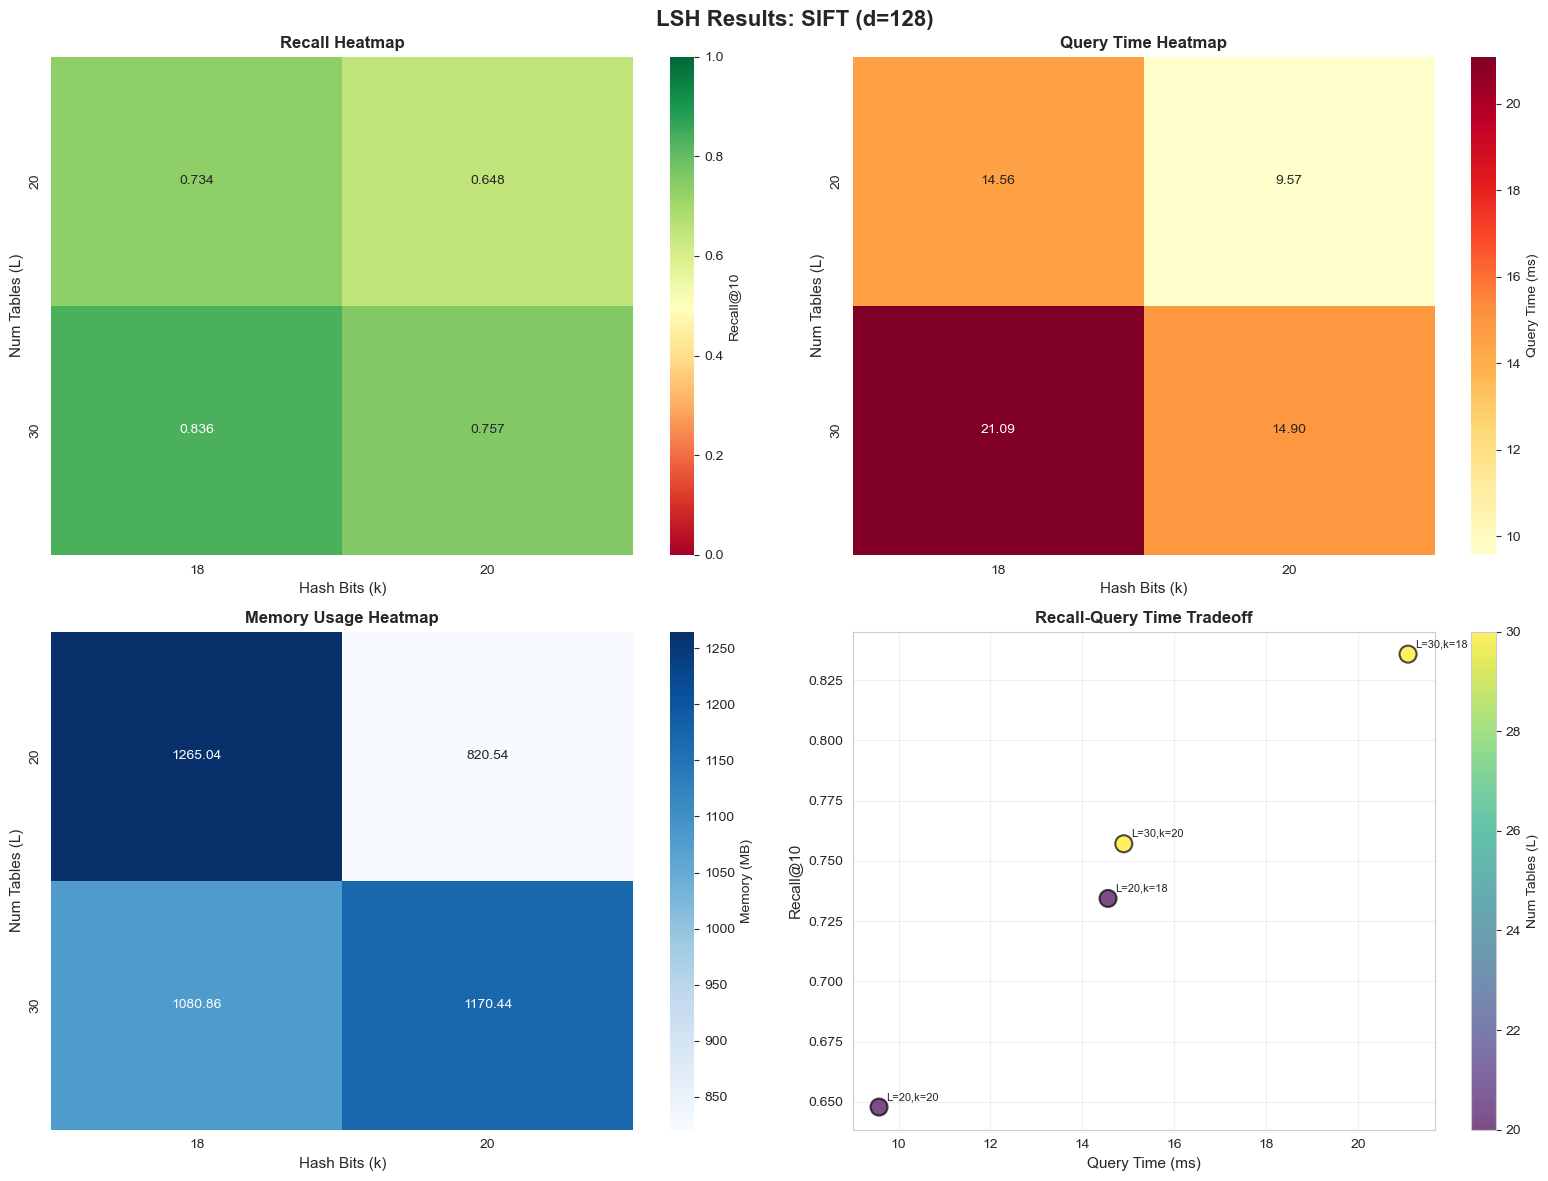

Plot saved to ../results/lsh_sift_tradeoffs.png

Plotting results for GIST...


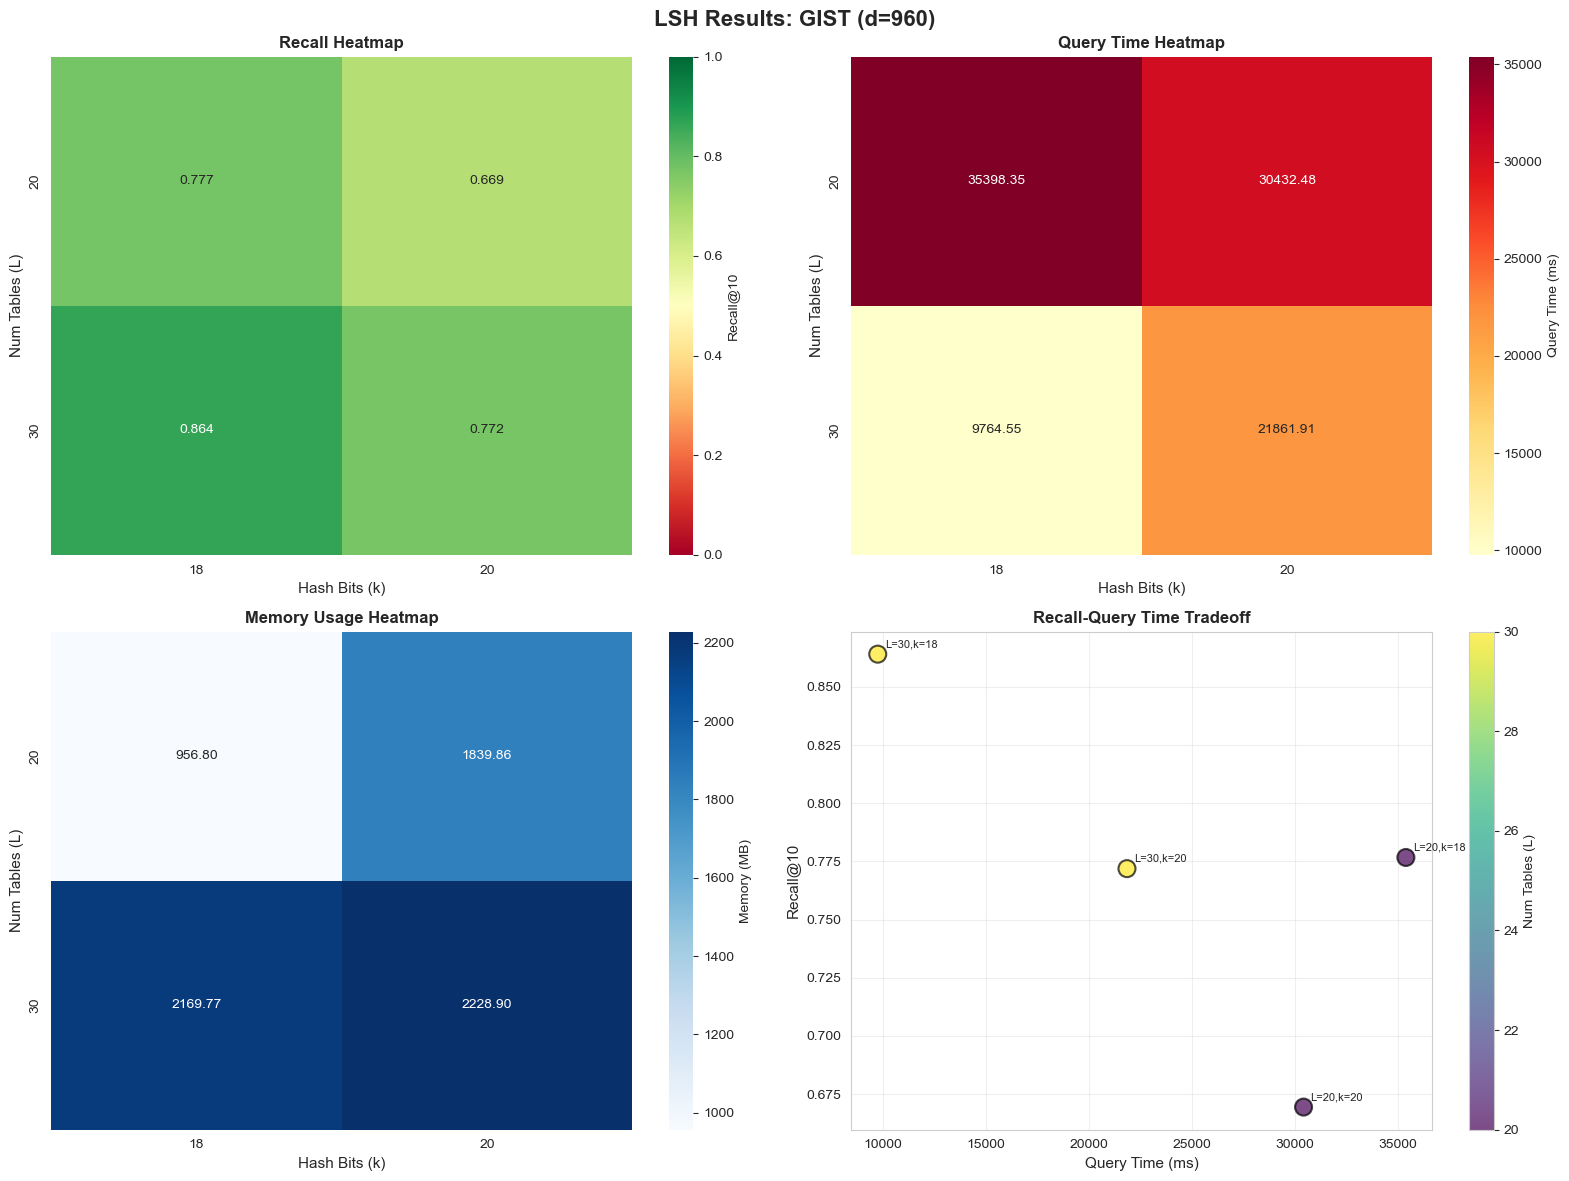

Plot saved to ../results/lsh_gist_tradeoffs.png

Plotting results for DEEP1B...


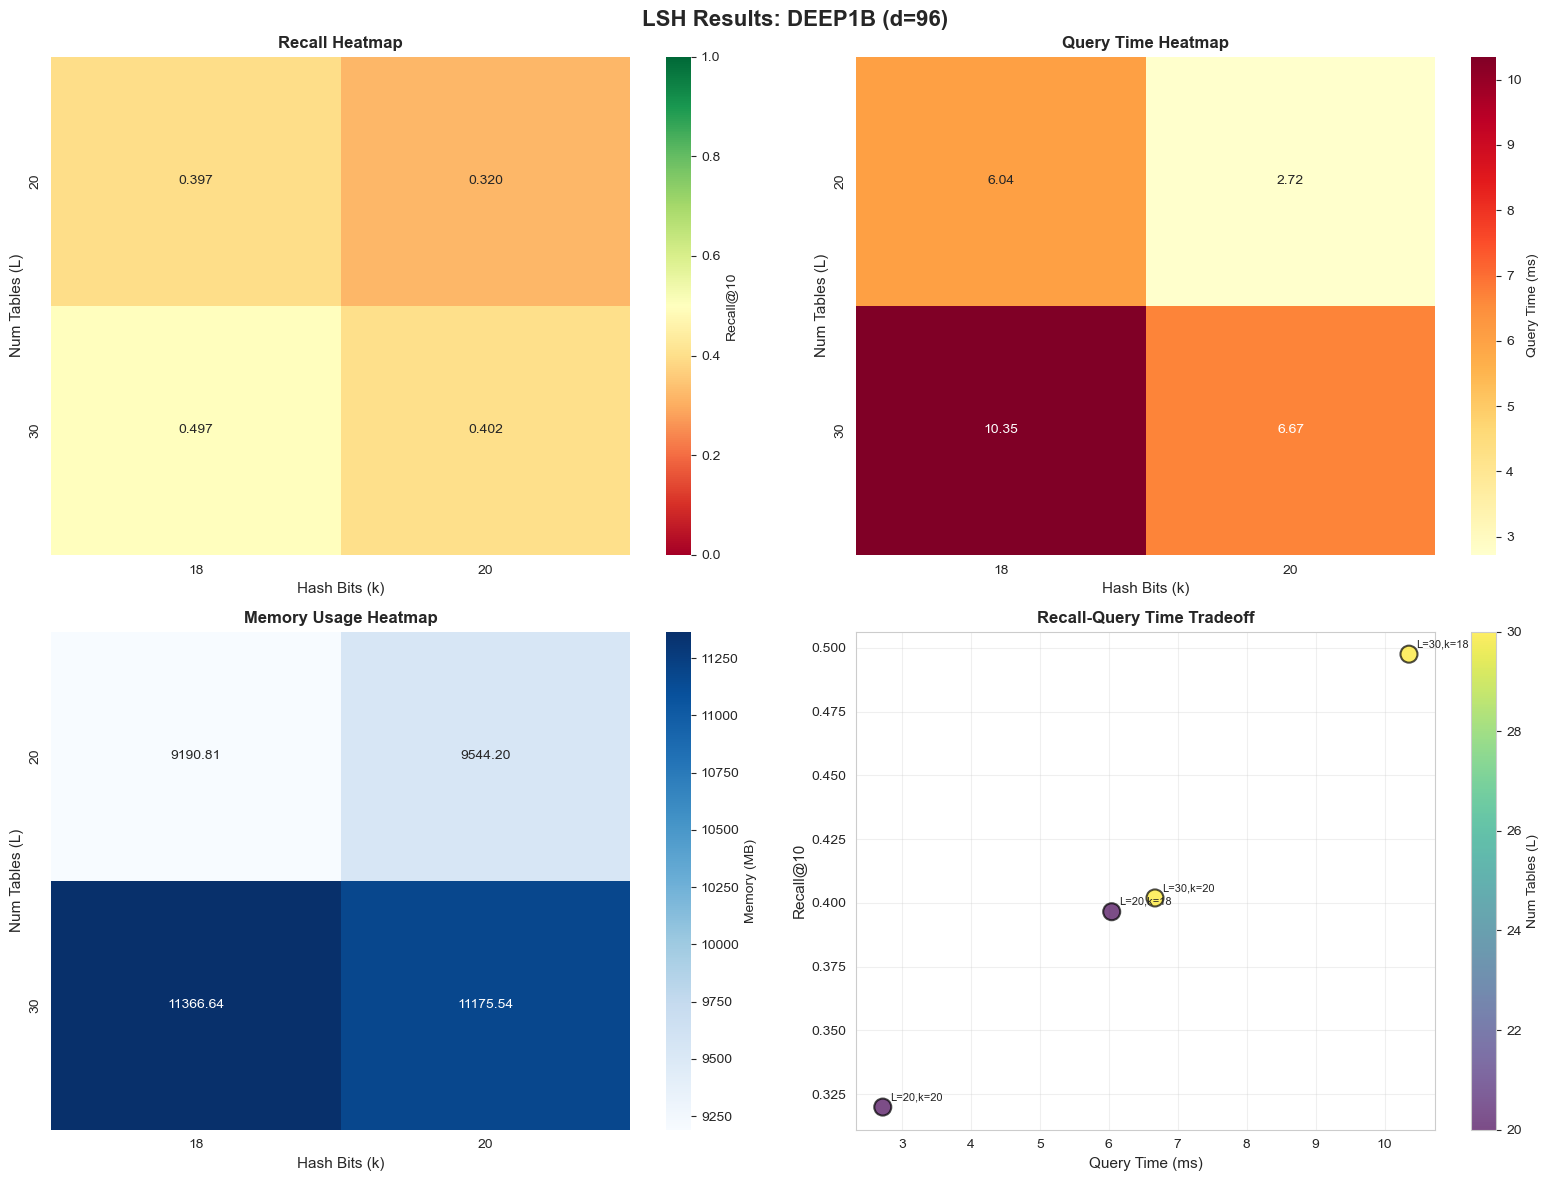

Plot saved to ../results/lsh_deep1b_tradeoffs.png


In [8]:
# Create per-dataset plots
for dataset_name, results_list in all_results.items():
    if not results_list:
        continue
    
    print(f"\nPlotting results for {dataset_name.upper()}...")
    
    # Extract data
    num_tables_list = [r['lsh_num_tables'] for r in results_list]
    hash_bits_list = [r['lsh_hash_bits'] for r in results_list]
    recalls = [r['recall@k'] for r in results_list]
    query_times = [r['avg_query_time_ms'] for r in results_list]
    memories = [r['memory_mb'] for r in results_list]
    d = results_list[0]['d']
    
    # Create pivot tables for heatmaps
    recall_pivot = np.zeros((len(NUM_TABLES_OPTIONS), len(HASH_BITS_OPTIONS)))
    query_time_pivot = np.zeros((len(NUM_TABLES_OPTIONS), len(HASH_BITS_OPTIONS)))
    memory_pivot = np.zeros((len(NUM_TABLES_OPTIONS), len(HASH_BITS_OPTIONS)))
    
    for r in results_list:
        i = NUM_TABLES_OPTIONS.index(r['lsh_num_tables'])
        j = HASH_BITS_OPTIONS.index(r['lsh_hash_bits'])
        recall_pivot[i, j] = r['recall@k']
        query_time_pivot[i, j] = r['avg_query_time_ms']
        memory_pivot[i, j] = r['memory_mb']
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'LSH Results: {dataset_name.upper()} (d={d})', fontsize=16, fontweight='bold')
    
    # 1. Recall Heatmap
    sns.heatmap(recall_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                xticklabels=HASH_BITS_OPTIONS, yticklabels=NUM_TABLES_OPTIONS,
                vmin=0, vmax=1, ax=axes[0, 0], cbar_kws={'label': f'Recall@{K}'})
    axes[0, 0].set_xlabel('Hash Bits (k)', fontsize=11)
    axes[0, 0].set_ylabel('Num Tables (L)', fontsize=11)
    axes[0, 0].set_title('Recall Heatmap', fontsize=12, fontweight='bold')
    
    # 2. Query Time Heatmap
    sns.heatmap(query_time_pivot, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=HASH_BITS_OPTIONS, yticklabels=NUM_TABLES_OPTIONS,
                ax=axes[0, 1], cbar_kws={'label': 'Query Time (ms)'})
    axes[0, 1].set_xlabel('Hash Bits (k)', fontsize=11)
    axes[0, 1].set_ylabel('Num Tables (L)', fontsize=11)
    axes[0, 1].set_title('Query Time Heatmap', fontsize=12, fontweight='bold')
    
    # 3. Memory Usage Heatmap
    sns.heatmap(memory_pivot, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=HASH_BITS_OPTIONS, yticklabels=NUM_TABLES_OPTIONS,
                ax=axes[1, 0], cbar_kws={'label': 'Memory (MB)'})
    axes[1, 0].set_xlabel('Hash Bits (k)', fontsize=11)
    axes[1, 0].set_ylabel('Num Tables (L)', fontsize=11)
    axes[1, 0].set_title('Memory Usage Heatmap', fontsize=12, fontweight='bold')
    
    # 4. Recall vs Query Time (Pareto frontier)
    scatter = axes[1, 1].scatter(query_times, recalls, s=150, 
                                c=num_tables_list, cmap='viridis', 
                                alpha=0.7, edgecolors='black', linewidth=1.5)
    # Add labels
    for i, (nt, hb) in enumerate(zip(num_tables_list, hash_bits_list)):
        axes[1, 1].annotate(f'L={nt},k={hb}', 
                           (query_times[i], recalls[i]),
                           textcoords="offset points", 
                           xytext=(5,5), ha='left', fontsize=8)
    axes[1, 1].set_xlabel('Query Time (ms)', fontsize=11)
    axes[1, 1].set_ylabel(f'Recall@{K}', fontsize=11)
    axes[1, 1].set_title('Recall-Query Time Tradeoff', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('Num Tables (L)', fontsize=10)
    
    plt.tight_layout()
    plot_path = os.path.join(RESULTS_DIR, f'lsh_{dataset_name}_tradeoffs.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {plot_path}")

## 5. Find Best Configurations

For each dataset, identify the best LSH configuration based on different criteria.

In [9]:
if all_results:
    print("\n" + "="*80)
    print("BEST CONFIGURATIONS PER DATASET")
    print("="*80 + "\n")
    
    for dataset_name, results_list in all_results.items():
        if not results_list:
            continue
        
        print(f"\n{dataset_name.upper()}:")
        print("-" * 60)
        
        # Best recall
        best_recall = max(results_list, key=lambda x: x['recall@k'])
        print(f"\n  Best Recall:")
        print(f"    L={best_recall['lsh_num_tables']}, k={best_recall['lsh_hash_bits']}")
        print(f"    Recall@{K}: {best_recall['recall@k']:.4f}")
        print(f"    Query time: {best_recall['avg_query_time_ms']:.3f} ms")
        print(f"    Memory: {best_recall['memory_mb']:.3f} MB")
        
        # Fastest query time (with recall >= 0.8)
        high_recall_configs = [r for r in results_list if r['recall@k'] >= 0.8]
        if high_recall_configs:
            fastest = min(high_recall_configs, key=lambda x: x['avg_query_time_ms'])
            print(f"\n  Fastest Query Time (Recall ≥ 0.8):")
            print(f"    L={fastest['lsh_num_tables']}, k={fastest['lsh_hash_bits']}")
            print(f"    Recall@{K}: {fastest['recall@k']:.4f}")
            print(f"    Query time: {fastest['avg_query_time_ms']:.3f} ms")
            print(f"    Memory: {fastest['memory_mb']:.3f} MB")
        
        # Most memory efficient (with recall >= 0.8)
        if high_recall_configs:
            mem_efficient = min(high_recall_configs, key=lambda x: x['memory_mb'])
            print(f"\n  Most Memory Efficient (Recall ≥ 0.8):")
            print(f"    L={mem_efficient['lsh_num_tables']}, k={mem_efficient['lsh_hash_bits']}")
            print(f"    Recall@{K}: {mem_efficient['recall@k']:.4f}")
            print(f"    Query time: {mem_efficient['avg_query_time_ms']:.3f} ms")
            print(f"    Memory: {mem_efficient['memory_mb']:.3f} MB")
        
        print()


BEST CONFIGURATIONS PER DATASET


SIFT:
------------------------------------------------------------

  Best Recall:
    L=30, k=18
    Recall@10: 0.8358
    Query time: 21.088 ms
    Memory: 1080.859 MB

  Fastest Query Time (Recall ≥ 0.8):
    L=30, k=18
    Recall@10: 0.8358
    Query time: 21.088 ms
    Memory: 1080.859 MB

  Most Memory Efficient (Recall ≥ 0.8):
    L=30, k=18
    Recall@10: 0.8358
    Query time: 21.088 ms
    Memory: 1080.859 MB


GIST:
------------------------------------------------------------

  Best Recall:
    L=30, k=18
    Recall@10: 0.8641
    Query time: 9764.545 ms
    Memory: 2169.773 MB

  Fastest Query Time (Recall ≥ 0.8):
    L=30, k=18
    Recall@10: 0.8641
    Query time: 9764.545 ms
    Memory: 2169.773 MB

  Most Memory Efficient (Recall ≥ 0.8):
    L=30, k=18
    Recall@10: 0.8641
    Query time: 9764.545 ms
    Memory: 2169.773 MB


DEEP1B:
------------------------------------------------------------

  Best Recall:
    L=30, k=18
    Recal

## 6. Summary Statistics Table

In [10]:
# Flatten all results for summary
all_results_flat = []
for dataset_name, results_list in all_results.items():
    all_results_flat.extend(results_list)

if all_results_flat:
    print("\n" + "="*100)
    print("SUMMARY: ALL LSH CONFIGURATIONS")
    print("="*100)
    
    # Header
    print(f"{'Dataset':<10} {'L':<6} {'k':<6} {'Recall@10':<12} {'Query(ms)':<12} {'Memory(MB)':<12} {'Build(s)':<10}")
    print("-" * 100)
    
    # Sort by dataset, then num_tables, then hash_bits
    sorted_results = sorted(all_results_flat, 
                          key=lambda x: (x['dataset'], x['lsh_num_tables'], x['lsh_hash_bits']))
    
    for r in sorted_results:
        print(f"{r['dataset'].upper():<10} "
              f"{r['lsh_num_tables']:<6} "
              f"{r['lsh_hash_bits']:<6} "
              f"{r['recall@k']:<12.4f} "
              f"{r['avg_query_time_ms']:<12.3f} "
              f"{r['memory_mb']:<12.3f} "
              f"{r['build_time_s']:<10.3f}")
    
    # Save comprehensive summary
    summary = {
        'experiment': 'LSH',
        'k': K,
        'n_test': N_TEST,
        'num_tables_options': NUM_TABLES_OPTIONS,
        'hash_bits_options': HASH_BITS_OPTIONS,
        'configurations_tested': len(all_results_flat),
        'results_by_dataset': all_results
    }
    
    summary_path = os.path.join(RESULTS_DIR, 'lsh_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\nComprehensive summary saved to {summary_path}")


SUMMARY: ALL LSH CONFIGURATIONS
Dataset    L      k      Recall@10    Query(ms)    Memory(MB)   Build(s)  
----------------------------------------------------------------------------------------------------
DEEP1B     20     18     0.3965       6.042        9190.809     150.209   
DEEP1B     20     20     0.3199       2.721        9544.199     189.775   
DEEP1B     30     18     0.4975       10.354       11366.645    216.748   
DEEP1B     30     20     0.4019       6.670        11175.535    289.729   
GIST       20     18     0.7767       35398.349    956.797      15.500    
GIST       20     20     0.6694       30432.484    1839.855     980.705   
GIST       30     18     0.8641       9764.545     2169.773     2750.550  
GIST       30     20     0.7719       21861.907    2228.898     32.162    
SIFT       20     18     0.7344       14.558       1265.035     12.756    
SIFT       20     20     0.6478       9.575        820.535      14.125    
SIFT       30     18     0.8358       21.

## 7. Key Observations

**Expected Results:**
- **More hash tables (L)**: Higher recall but slower query time and more memory
- **More hash bits (k)**: Finer bucketing → fewer candidates per bucket → lower recall but faster
- **Optimal balance**: Need enough L for high recall, but not so much that query time suffers

**LSH Theory:**
- LSH guarantees sublinear query time: O(n^ρ) where ρ < 1 depends on approximation factor
- Space complexity: O(nL) where L is number of tables
- More tables → better recall but more redundancy

**Tradeoffs:**
- **High L, Low k**: Best recall, slower queries, more memory
- **Low L, High k**: Fast queries, less memory, but lower recall
- **Sweet spot**: Find (L, k) where recall ≥ 0.9 with reasonable query time

**Next Steps:**
Compare these results against:
1. Baseline brute-force KNN (notebook 01)
2. JL+KNN (notebook 02)
3. JL+LSH combination (future work)